In [1]:
#%env PYOPENCL_COMPILER_OUTPUT=1
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time
import sys

from methods.generic_methods_cl import Communicator
from particles import Particles
from grid import Grid

comm = Communicator(answers=[0,2])

Device of GPU-type is chosen


# CHIMERA(.CL)
## Project of a PSATD PIC code on heterogeneous architectures

[![CRAN](https://img.shields.io/cran/l/devtools.svg)](LICENSE)

by Igor A Andriyash (<igor.andriyash@gmail.com>)

CHIMERA(.CL) is a project of a relativistic electromagnetic particle-in-cell code, based on a quasi-cylindric pseudo-spectral analytical time domain (PSATD) Maxwell solver. More details on this method can be found in the original publications [<cite>[1]</cite>,<cite>[2]</cite>,<cite>[3]</cite>]. 

The project spins off from the original code <cite>[CHIMERA]</cite> and is aimed to be firstly a playground to learn (py)openCL approach to GPGPU programming.
The second goal of CHIMERA(.CL) is to design the code with maximum flexibility:
- code should be divided into (i) wrapper classes that are independent of computational part (e.g. particles.py and grid.py), and (ii) compiled methods (cf ./methods/) as much general as  possible.
- computational data should be presented with 'device' abstraction
- all data structures should be grouped into containers of dictionary type with comprehensive naming

Presenly developed methods are using <cite>[openCL]</cite> via <cite>[PyOpenCL]</cite> API which also benefits from few methods provided by <cite>[Reikna]</cite>. 
In future work it is planed to add methods based on openMP enabled Fortran routines.

System requirements
- Linux or MacOS (not tested on Windows)
- python distribution with numpy and scipy
- <cite>[openCL]</cite> driver (tested with version 1.2 )
- <cite>[PyOpenCL]</cite>
- <cite>[Reikna]</cite> library
- <cite>[pyFFTW]</cite> (REIKNA's fft crashes on Apple CPUs, cause Apple are geniuses)

*NB*: This is a very early, non-functional version and presently it's used only for debuggin and timing of the PSATD PIC cycle piecies: deposition, projection, sorting, tranforms etc.

\[[1]\] Igor A. Andriyash, Remi Lehe and Agustin Lifschitz, *Laser-plasma interactions with a Fourier-Bessel particle-in-cell method*, Physics of Plasmas **23**, 033110 
(2016)

\[[2]\] Remi Lehe, Manuel Kirchen, Igor A. Andriyash, Brendan B. Godfrey and Jean-Luc Vay, *A spectral, quasi-cylindrical and dispersion-free Particle-In-Cell algorithm*, 
Computer Physics Communications **203**, 66 (2016)

\[[3]\] Igor A. Andriyash, Remi Lehe and Victor Malka, *A spectral unaveraged algorithm for free electron laser simulations*, Journal of Computational Physics **282**, 397 (2015)

[1]:http://dx.doi.org/10.1063/1.4943281
[2]:http://dx.doi.org/10.1016/j.cpc.2016.02.007
[3]:http://dx.doi.org/10.1016/j.jcp.2014.11.026
[CHIMERA]:https://github.com/hightower8083/chimera
[openCL]: https://www.khronos.org/opencl
[PyOpenCL]:https://mathema.tician.de/software/pyopencl
[Reikna]:http://reikna.publicfields.net
[pyFFTW]:https://github.com/hgomersall/pyFFTW

In [2]:
grid_in = {
    'Xmin':-1.,'Xmax':1.,'Nx':1024,
    'Rmin':0,'Rmax':1.,'Nr':256,
    'M':0
}
parts = Particles(grid_in,comm)
grid = Grid(grid_in,comm)
    
beam_in = {'Np':int(7e6),
           'x_c':0.,'Lx':0.2,
           'y_c':0.,'Ly':0.2,
           'z_c':0.,'Lz':0.2,
           'px_c':0.,'dpx':0.5,
           'py_c':0.,'dpy':0.5,
           'pz_c':0.,'dpz':0.5,
          }

parts.make_parts(beam_in)
parts.sort_parts_full()

/Users/igor/anaconda3/lib/python3.6/site-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [3]:
Nint = 100
Nheatup = 10
sorting_indx = parts.sort_rdx(parts.DataDev['indx_in_cell'])

for i in range(Nint+Nheatup):
    if i==Nheatup: t0 = time()
    parts.align_and_damp_tst(sorting_indx,comps=['x','y','z','px','py','pz','g_inv','w'])
comm.thr.synchronize()    
print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 100 loops is 124.043 ms


In [3]:
parts.sort_parts_full()

Nint = 50
t0 = time()
for i in range(Nint):
    grid.depose_charge([parts,])
comm.thr.synchronize()

print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 50 loops is 45.2386 ms


In [5]:
Nint = 50
t0 = time()
for i in range(Nint):
    grid.depose_currents([parts,])
comm.thr.synchronize()

print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 50 loops is 97.8985 ms


In [8]:
Nsteps = 750
for i in range(Nsteps):
    parts.push_coords()
    #parts.sort_parts_full()
    #grid.depose_charge([parts,])
    #grid.fb_transform(comps = ['rho',],dir=0)
    sys.stdout.write('\r'+str(i+1)+'/'+str(Nsteps))
    sys.stdout.flush()

750/250

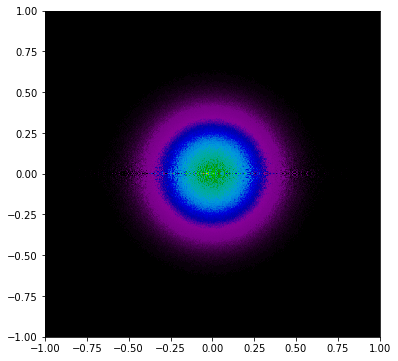

In [3]:
#parts.sort_parts_full()
grid.depose_charge([parts,])
plt.figure(figsize=(6,6))
var = np.real(grid.DataDev['rho_m0'].get())
var = np.vstack((var[1:][::-1],var[2:]))
plt.imshow(var,interpolation='none',
           origin='lower',aspect='auto',cmap=plt.cm.spectral,vmin=0,
           extent=(grid.Args['Xmin'],grid.Args['Xmax'],-grid.Args['Rmax'],grid.Args['Rmax']),
           )
#plt.colorbar()
#plt.xlim(-0.4,0.4)
#plt.ylim(-0.4,0.4)

In [1]:
grid.depose_charge([parts,])

plt.figure(figsize=(6,6))
var = np.real(grid.DataDev['rho_m0'].get())
plt.imshow(var,interpolation='none',
           origin='lower',aspect='auto',
           extent=(grid.Args['Xmin'],grid.Args['Xmax'],grid.Args['Rmin'],grid.Args['Rmax']),
           )
plt.colorbar()

NameError: name 'grid' is not defined

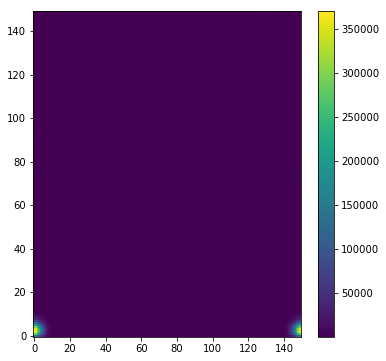

In [6]:
grid.fb_transform(comps = ['rho',])

plt.figure(figsize=(6,6))

var = np.abs(grid.DataDev['rho_fb_m0'].get())

plt.imshow(var,interpolation='none', origin='lower',
           aspect='auto', )
plt.colorbar()

(0, 1.05)

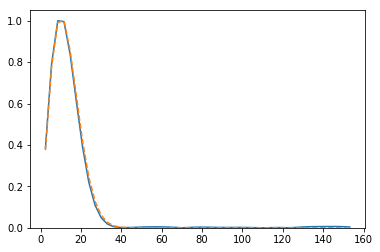

In [6]:
from scipy.special import jn

var_spc = np.abs(grid.DataDev['field_fb_aux1_dbl'].get())
var_dht = np.abs(grid.DataDev['field_fb_aux2_dbl'].get())

rr = grid.Args['Rgrid'][1:]
kr = grid.Args['kr_m0']
r_period = grid.Args['Rmax']+0.5*grid.Args['dr']

var_analyt = np.exp(-0.5*rr**2/0.1**2)
var_dht_analyt =  np.exp(-0.5*kr**2*0.1**2)/jn(1,kr*r_period)**2
var_dht_analyt /= var_dht_analyt.max()

#plt.semilogy(rr, var_spc[:,49]/var_spc[:,49].max())
#plt.semilogy(rr, var_analyt)

plt.plot(kr,var_dht[:,24]/var_dht[:,24].max())
plt.plot(kr,var_dht_analyt,'--')
plt.ylim(0,)

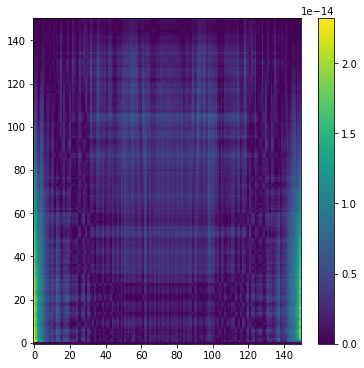

In [22]:
tmp = grid.DataDev['rho_m0'].get().copy()
grid.fb_transform(comps = ['rho',],dir=0)
grid.DataDev['rho_m0'][:] = 0.
grid.fb_transform(comps = ['rho',],dir=1)

var = np.abs(grid.DataDev['rho_m0'].get()[:,:-1]-tmp[:,:-1])/np.abs(tmp[:,:-1]).max()

plt.figure(figsize=(6,6))
plt.imshow((var),interpolation='none',
           origin='lower',aspect='auto',
           )
plt.colorbar()

In [5]:
Nint = 50
t0 = time()
for i in range(Nint):
    parts.sort_parts_full()
comm.thr.synchronize()    
print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 50 loops is 153.348 ms


In [16]:
Nint = 50
t0 = time()
for i in range(Nint):
    parts.index_and_sum()
comm.thr.synchronize()
print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 50 loops is 6.95964 ms


In [8]:
Nint = 500
t0 = time()
for i in range(Nint):
    parts.DataDev['x'][:] = 0.
comm.thr.synchronize()    
print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 500 loops is 1.70137 ms


In [6]:
Nint = 50
t0 = time()
for i in range(Nint):
    grid.depose_charge([parts,])
    
comm.thr.synchronize()
print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 50 loops is 25.0122 ms


In [8]:
Nint = 100
t0 = time()
for i in range(Nint):
    grid.fb_transform()
comm.thr.synchronize()
print( "Timing averaged over {:d} loops is {:g} ms".
      format(Nint,(time()-t0)/Nint*1e3) )

Timing averaged over 100 loops is 28.4816 ms


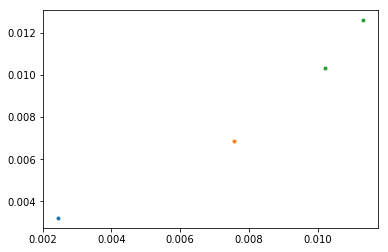

In [8]:
x,y,z = parts.DataDev['x'].get(),parts.DataDev['y'].get(),parts.DataDev['z'].get()

offst = parts.DataDev['cell_offset'].get()

r = np.sqrt(y**2+z**2)

ix = parts.Args['Nx']//2
ir = 1
icell = ix + ir*parts.Args['Nx']
plt.plot(x[offst[icell]:offst[icell+1]],r[offst[icell]:offst[icell+1]],'.')

ix = parts.Args['Nx']//2+1
ir = 2
icell = ix + ir*parts.Args['Nx']
plt.plot(x[offst[icell]:offst[icell+1]],r[offst[icell]:offst[icell+1]],'.')

ix = parts.Args['Nx']//2+2
ir = 3
icell = ix + ir*parts.Args['Nx']
plt.plot(x[offst[icell]:offst[icell+1]],r[offst[icell]:offst[icell+1]],'.')

In [21]:
from reikna.linalg import MatrixMul

In [10]:
parts.DataDev['x'].max()

AttributeError: 'Array' object has no attribute 'max'

In [6]:
dev = comm.ctx.devices[0]

In [7]:
    dev.max_work_group_size

256